#### <font color='purple'> [Elliptical Galaxies Defn](#1)
#### <font color='purple'> [Disk Galaxies Defn](#2)
#### <font color='darkviolet'> [Physical Formula Manually](#3)
#### <font color='purple'>[1. Disk Galaxies](#4)
#### <font color='darkorange'>[1.b. Small vdiks: Vdisk<=1.0 cases](#5)
#### <font color='darkorange'>[1.c. Big vdiks: Vdisk>1.0 cases](#6)                                              ####<font color='darkgreen'>[1.d. Big vdisks in 3 different bins](#7)  
##### <font color='darkgreen'>[1.d.1. Population 1: 1.0<=Vdisk<1.15](#8)
     
[Elliptical Galaxies](#10)




### This code provides analysis on the procedure to extract the physical model of galaxy sizes manually, using the most important features as identified in notebook TNG-SAM_z=0_v13. 
#### The approach is to first look at the best different physical models per galaxy morphology: Disk, Bulgy Disks, Bulgier Disks and Ellipticals.
#### The model derived for Disks in this notebook doesn't take into account small size galaxies (spin ~0.2; the vertical part of the hockeey stick). The models derived for Disks are then applied on Bulgy Disks to see their performance.



In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

from scipy.optimize import curve_fit

#### <font color='violet'> ML modelling with 33 galaxy and halo features; df from v5 used here


#### Read the normalized 31-feature dataset (see explanations in related doc 'TNG-SAM 33-feature analysis')

In [2]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

#### Add the column 'BulgeMstar_ratio' defined as Bulge mass / Stellar mass, to be used as a proxy for galaxy morphology

In [3]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']


In [4]:
df_normalized_31.shape

(35390, 33)

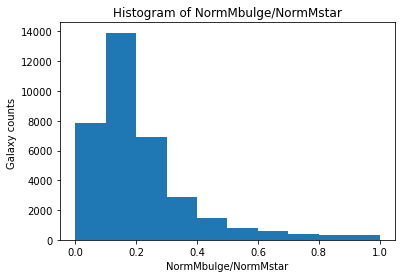

In [5]:
plt.hist(df_normalized_31['BulgeMstar_ratio'])
plt.title('Histogram of NormMbulge/NormMstar')
plt.xlabel('NormMbulge/NormMstar')
plt.ylabel('Galaxy counts ')
# plt.savefig('Histogram of GalpropNormMbulgebyNormMstar.jpg', dpi=500)

plt.show()

## <font color='purple'> <a id =2> </a> <br>Disk Galaxies Defn

In [9]:
df_disks = pd.read_csv('Disks Dataset_as defined in notebook v13')

In [10]:
df_disks.shape

(15717, 33)

In [11]:
X_disks = df_disks.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_disks = df_disks.loc[:,'GalpropNormHalfRadius']

--------------------

## <font color='darkviolet'> <a id =3> </a> <br>Physical Formula Manually Derived

## <font color='purple'> <a id =4> </a> <br> 1. Disk Galaxies

Randomly sample df_disks to extract 10,000 galaxies out of total ~15,000 beause SR works with at most 10,000 entries


In [13]:
# choose the 7 most important features from analysis above to be used for physical modelling

X_disks_imp = df_disks.loc[:, ['HalopropSpin', 'GalpropNormVdisk',
                              'GalpropNormMHI', 'HalopropC_nfw', 'GalpropNormMbulge',
                              'GalpropNormMH2', 'GalpropNormMstar' ]]


y_disks_imp = df_disks.loc[:, 'GalpropNormHalfRadius']

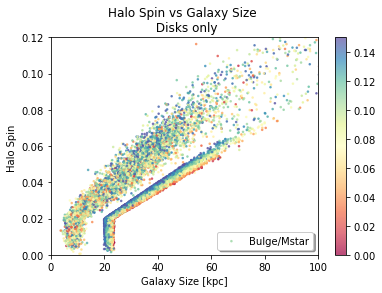

In [14]:
plt.scatter(y_disks_imp, X_disks_imp.loc[:, 'HalopropSpin'],
            c = df_disks['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'Bulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Disks only')
plt.xlabel('Galaxy Size [kpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_disks_samplesize14000.jpeg', dpi=500)
plt.show()

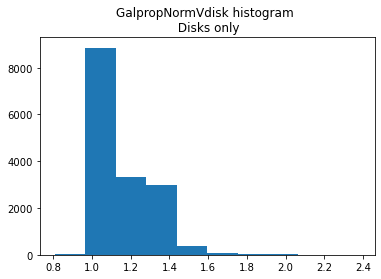

In [15]:
plt.hist(df_disks['GalpropNormVdisk'])
plt.title('GalpropNormVdisk histogram \n Disks only')
# plt.savefig('GalpropNormVdisk_disksonly_histogram', dpi=500)
plt.show()

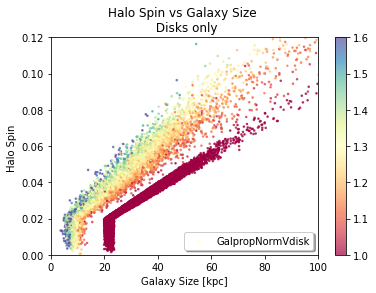

In [16]:
plt.scatter(y_disks_imp, X_disks_imp.loc[:, 'HalopropSpin'],
            c = df_disks['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Disks only')
plt.xlabel('Galaxy Size [kpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_disks_samplesize14000_vdisksmallerscale.jpeg', dpi=500)
plt.show()

### 1.a. Remove all disk sizes <24

In [17]:
df_disks.shape

(15717, 33)

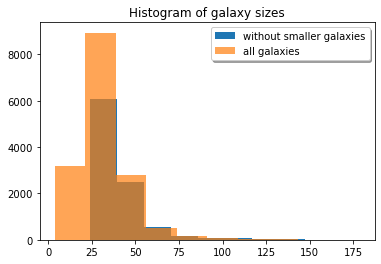

In [18]:
df_disks_wosmallgalaxies = df_disks.loc[df_disks.GalpropNormHalfRadius > 24]

plt.hist (df_disks_wosmallgalaxies['GalpropNormHalfRadius'], label = 'without smaller galaxies')
plt.hist (df_disks['GalpropNormHalfRadius'], alpha=0.7, label = 'all galaxies')
plt.title ('Histogram of galaxy sizes')
plt.legend (loc='upper right' , shadow=True)
plt.show()

In [19]:
df_disks_wosmallgalaxies.shape # there are 2,512 galaxies with size <=20 kpc
                               # there are 5,514 galaxies with size <=23 kpc
                               # there are 6,254 galaxies with size <=24 kpc -- this is where the vertical line of the hockey stick in the size-spin plot disappears
                               # there are 6,701 galaxies with size <= 25 kpc

(9463, 33)

### <font color='darkorange'> <a id =5> </a> <br>  1.b. Small vdiks: Vdisk<=1.0 cases

In [20]:
df_disks_smallv = df_disks_wosmallgalaxies.loc[df_disks_wosmallgalaxies.GalpropNormVdisk<=1.0]

In [21]:
df_disks_smallv.shape

(5392, 33)

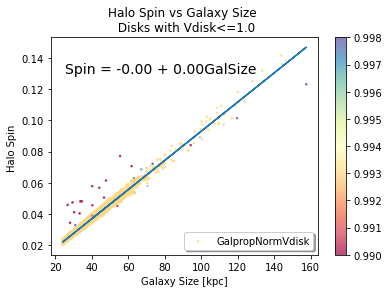

In [22]:
#find line of best fit
a1, b1 = np.polyfit(df_disks_smallv.loc[:, 'GalpropNormHalfRadius'], df_disks_smallv.loc[:, 'HalopropSpin'], 1)

plt.scatter(df_disks_smallv.loc[:, 'GalpropNormHalfRadius'], df_disks_smallv.loc[:, 'HalopropSpin'],
            c = df_disks_smallv['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=0.99, vmax=0.998)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Disks with Vdisk<=1.0')
plt.xlabel('Galaxy Size [kpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_disks_smallv.loc[:, 'GalpropNormHalfRadius'], a1*df_disks_smallv.loc[:, 'GalpropNormHalfRadius']+b1) 
#add fitted regression equation to plot
plt.text(25, 0.13, 'Spin = ' + '{:.2f}'.format(b1) + ' + {:.2f}'.format(a1) + 'GalSize', size=14)

# plt.savefig('Spin_vs_size_disks_smallvdisk_polyfit.jpeg', dpi=500)
plt.show()

In [23]:
df_disks_smallv['GalpropNormVdisk'].value_counts()

0.993084    6
0.993084    5
0.993083    5
0.993082    5
0.993082    4
           ..
0.993084    1
0.993083    1
0.993082    1
0.993084    1
0.993084    1
Name: GalpropNormVdisk, Length: 4557, dtype: int64

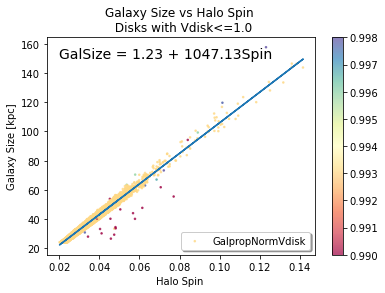

In [24]:
#find line of best fit
a2, b2 = np.polyfit(df_disks_smallv.loc[:, 'HalopropSpin'],df_disks_smallv.loc[:, 'GalpropNormHalfRadius'] , 1)

plt.scatter(df_disks_smallv.loc[:, 'HalopropSpin'], df_disks_smallv.loc[:, 'GalpropNormHalfRadius'],
            c = df_disks_smallv['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=0.99, vmax=0.998)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('Galaxy Size vs Halo Spin \n Disks with Vdisk<=1.0')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_disks_smallv.loc[:, 'HalopropSpin'], a2*df_disks_smallv.loc[:, 'HalopropSpin']+b2) 

#add fitted regression equation to plot
plt.text(0.02, 150, 'GalSize = ' + '{:.2f}'.format(b2) + ' + {:.2f}'.format(a2) + 'Spin', size=14)
# plt.savefig('Size_vs_spin_disks_wosmallgalaxies_smallvdisk_polyfit.jpeg', dpi=500)
plt.show()

In [25]:
galsize_smallv = 1.23 + 1047.13 * df_disks_smallv['HalopropSpin']

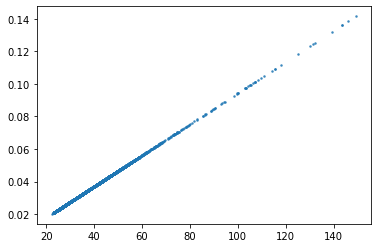

In [26]:
plt.scatter(galsize_smallv, df_disks_smallv.loc[:, 'HalopropSpin'], alpha=0.7, s=10, marker='.' )
plt.show()

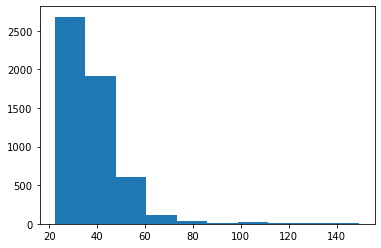

In [27]:
plt.hist(galsize_smallv)
plt.show()

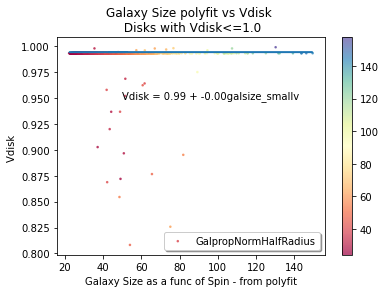

In [28]:
#find line of best fit
a5, b5 = np.polyfit(galsize_smallv ,df_disks_smallv.loc[:, 'GalpropNormVdisk'] , 1)

plt.scatter(galsize_smallv, df_disks_smallv.loc[:, 'GalpropNormVdisk'],  
            c = df_disks_smallv['GalpropNormHalfRadius'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormHalfRadius') #, vmin=0.06, vmax=0.13)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('Galaxy Size polyfit vs Vdisk \n Disks with Vdisk<=1.0')
plt.xlabel('Galaxy Size as a func of Spin - from polyfit')
plt.ylabel('Vdisk ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(galsize_smallv, a5*df_disks_smallv.loc[:, 'GalpropNormVdisk']+b5) 

#add fitted regression equation to plot
plt.text(50.0, 0.950, 'Vdisk = ' + '{:.2f}'.format(b5) + ' + {:.2f}'.format(a5) + 'galsize_smallv', size=10)
# plt.savefig('Vdisk_vs_galsize_smallvdisk_polyfit.jpeg', dpi=500)
plt.show()

### <font color='darkorange'> <a id =6> </a> <br>  1.c. Big vdisk: Vdisk>1.0 cases

In [29]:
df_disks_bigv = df_disks_wosmallgalaxies.loc[df_disks_wosmallgalaxies.GalpropNormVdisk>1.0]

In [30]:
df_disks_bigv.shape

(4071, 33)

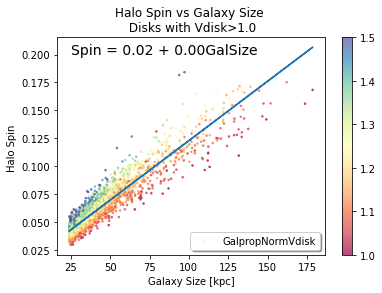

In [31]:
#find line of best fit
a3, b3 = np.polyfit(df_disks_bigv.loc[:, 'GalpropNormHalfRadius'], df_disks_bigv.loc[:, 'HalopropSpin'], 1)

plt.scatter(df_disks_bigv.loc[:, 'GalpropNormHalfRadius'], df_disks_bigv.loc[:, 'HalopropSpin'],
            c = df_disks_bigv['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.5)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Disks with Vdisk>1.0')
plt.xlabel('Galaxy Size [kpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_disks_bigv.loc[:, 'GalpropNormHalfRadius'], a3*df_disks_bigv.loc[:, 'GalpropNormHalfRadius']+b3) 
#add fitted regression equation to plot
plt.text(25, 0.20, 'Spin = ' + '{:.2f}'.format(b3) + ' + {:.2f}'.format(a3) + 'GalSize', size=14)

# plt.savefig('Spin_vs_size_disks_bigvdisk_polyfit.jpeg', dpi=500)
plt.show()

In [32]:
df_disks_bigv['GalpropNormVdisk'].max()

1.7286558388609352

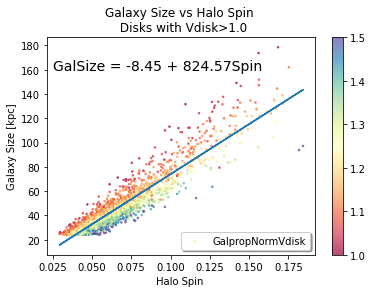

In [33]:
#find line of best fit
a4, b4 = np.polyfit(df_disks_bigv.loc[:, 'HalopropSpin'],df_disks_bigv.loc[:, 'GalpropNormHalfRadius'] , 1)

plt.scatter(df_disks_bigv.loc[:, 'HalopropSpin'], df_disks_bigv.loc[:, 'GalpropNormHalfRadius'],
            c = df_disks_bigv['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=1.0, vmax=1.5)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('Galaxy Size vs Halo Spin \n Disks with Vdisk>1.0')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_disks_bigv.loc[:, 'HalopropSpin'], a4*df_disks_bigv.loc[:, 'HalopropSpin']+b4) 

#add fitted regression equation to plot
plt.text(0.025, 160, 'GalSize = ' + '{:.2f}'.format(b4) + ' + {:.2f}'.format(a4) + 'Spin', size=14)
# plt.savefig('Size_vs_spin_disks_bigvdisk_polyfit.jpeg', dpi=500)
plt.show()

In [34]:
a4, b4   # a is slope, b is intercept

(824.5747299534922, -8.454167982695477)

In [35]:
galsize_bigv = -8.45 + 824.57 * df_disks_bigv['HalopropSpin']

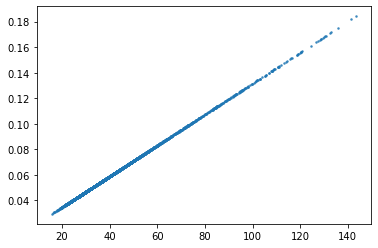

In [36]:
plt.scatter(galsize_bigv, df_disks_bigv.loc[:, 'HalopropSpin'], alpha=0.7, s=10, marker='.' )
plt.show()

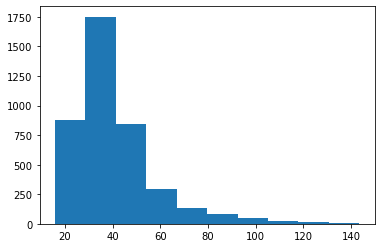

In [37]:
plt.hist(galsize_bigv)
plt.show()

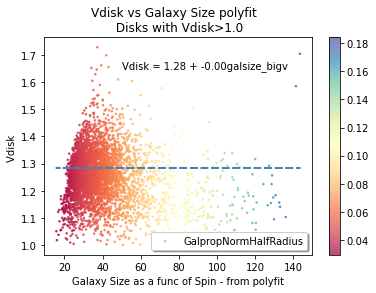

In [38]:
#find line of best fit
a6, b6 = np.polyfit(galsize_bigv ,df_disks_bigv.loc[:, 'GalpropNormVdisk'] , 1)

plt.scatter(galsize_bigv, df_disks_bigv.loc[:, 'GalpropNormVdisk'],  
            c = df_disks_bigv['HalopropSpin'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormHalfRadius') #, vmin=0.06, vmax=0.13)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('Vdisk vs Galaxy Size polyfit  \n Disks with Vdisk>1.0')
plt.xlabel('Galaxy Size as a func of Spin - from polyfit')
plt.ylabel('Vdisk ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
# plt.plot(x, a*x+b, color='steelblue', linestyle='--', linewidth=2)
plt.plot(galsize_bigv, a6*df_disks_bigv.loc[:, 'HalopropSpin']+b6 , color='steelblue', linestyle='--', linewidth=2) 

#add fitted regression equation to plot
plt.text(50.0, 1.65, 'Vdisk = ' + '{:.2f}'.format(b6) + ' + {:.2f}'.format(a6) + 'galsize_bigv', size=10)
# plt.savefig('Vdisk_vs_galsize_bigvdisk_polyfit.jpeg', dpi=500)
plt.show()

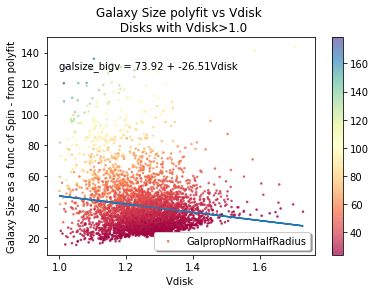

In [39]:
#find line of best fit
a7, b7 = np.polyfit(df_disks_bigv.loc[:, 'GalpropNormVdisk'], galsize_bigv , 1)

plt.scatter(df_disks_bigv.loc[:, 'GalpropNormVdisk'], galsize_bigv,  
            c = df_disks_bigv['GalpropNormHalfRadius'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormHalfRadius') #, vmin=0.06, vmax=0.13)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('Galaxy Size polyfit vs Vdisk \n Disks with Vdisk>1.0')
plt.ylabel('Galaxy Size as a func of Spin - from polyfit')
plt.xlabel('Vdisk ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
# plt.plot(x, a*x+b, color='steelblue', linestyle='--', linewidth=2)
plt.plot(df_disks_bigv.loc[:, 'GalpropNormVdisk'], a7*df_disks_bigv.loc[:, 'GalpropNormVdisk']+b7) 

#add fitted regression equation to plot
plt.text(1.0, 130, 'galsize_bigv = ' + '{:.2f}'.format(b7) + ' + {:.2f}'.format(a7) + 'Vdisk', size=10)
# plt.savefig('Vdisk_vs_galsize_bigvdisk_polyfit.jpeg', dpi=500)
plt.show()

### <font color='darkgreen'> <a id =7> </a> <br>  1.d. Big vdisks in 3 different bins

#### <font color='darkgreen'> <a id =8> </a> <br>  1.d.1. Population 1: 1.0 <= Vdisk < 1.15 

In [40]:
# Big Vdisk Population 1: 1.0 <= Vdisk < 1.15
df_disks_bigv_1 = df_disks_bigv.loc[(df_disks_bigv.GalpropNormVdisk>=1.0) &  
                                    (df_disks_bigv.GalpropNormVdisk<1.15)]

In [41]:
df_disks_bigv_1.shape

(629, 33)

In [42]:
a4, b4   # a is slope, b is intercept of Galsize (Spin) function

(824.5747299534922, -8.454167982695477)

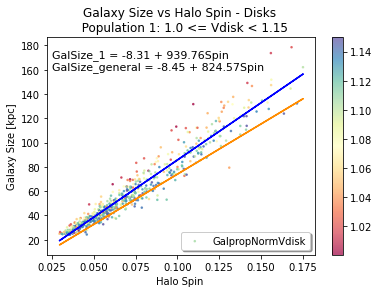

In [43]:
a8, b8 = np.polyfit(df_disks_bigv_1.loc[:, 'HalopropSpin'],df_disks_bigv_1.loc[:, 'GalpropNormHalfRadius'] , 1)


plt.scatter(df_disks_bigv_1.loc[:, 'HalopropSpin'], df_disks_bigv_1.loc[:, 'GalpropNormHalfRadius'],
            c = df_disks_bigv_1['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk') #, vmin=1.0, vmax=1.5)
plt.title('Galaxy Size vs Halo Spin - Disks \n  Population 1: 1.0 <= Vdisk < 1.15')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_disks_bigv_1.loc[:, 'HalopropSpin'], a8*df_disks_bigv_1.loc[:, 'HalopropSpin']+b8, color = 'blue') 
# line of best fit fromt he equation on the complete vdisk>1.0 population
plt.plot(df_disks_bigv_1.loc[:, 'HalopropSpin'], a4*df_disks_bigv_1.loc[:, 'HalopropSpin']+b4, color ='darkorange') 

#add fitted regression equation to plot
plt.text(0.025, 170, 'GalSize_1 = ' + '{:.2f}'.format(b8) + ' + {:.2f}'.format(a8) + 'Spin', size=11)
plt.text(0.025, 160, 'GalSize_general = ' + '{:.2f}'.format(b4) + ' + {:.2f}'.format(a4) + 'Spin', size=11)

# plt.savefig('Size_vs_spin_disks_vdisk_1.jpeg', dpi=500)

plt.show()

#### <font color='darkgreen'> <a id =8> </a> <br>  1.d.2. Population 2: 1.15 <= Vdisk < 1.25 

In [44]:
# Big Vdisk Population 2: 1.15 <= Vdisk < 1.25
df_disks_bigv_2 = df_disks_bigv.loc[(df_disks_bigv.GalpropNormVdisk>=1.15) &  
                                    (df_disks_bigv.GalpropNormVdisk<1.25)]

In [45]:
df_disks_bigv_2.shape

(1411, 33)

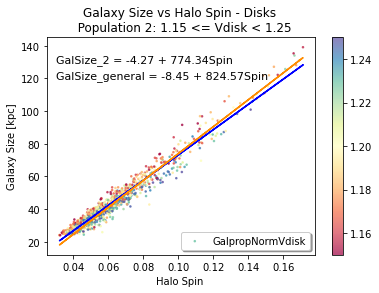

In [46]:
a9, b9 = np.polyfit(df_disks_bigv_2.loc[:, 'HalopropSpin'],df_disks_bigv_2.loc[:, 'GalpropNormHalfRadius'] , 1)

plt.scatter(df_disks_bigv_2.loc[:, 'HalopropSpin'], df_disks_bigv_2.loc[:, 'GalpropNormHalfRadius'],
            c = df_disks_bigv_2['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk') #, vmin=1.0, vmax=1.5)
plt.title('Galaxy Size vs Halo Spin - Disks \n  Population 2: 1.15 <= Vdisk < 1.25')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_disks_bigv_2.loc[:, 'HalopropSpin'], a9*df_disks_bigv_2.loc[:, 'HalopropSpin']+b9, color = 'blue') 
# line of best fit fromt he equation on the complete vdisk>1.0 population
plt.plot(df_disks_bigv_2.loc[:, 'HalopropSpin'], a4*df_disks_bigv_2.loc[:, 'HalopropSpin']+b4, color = 'darkorange') 

#add fitted regression equation to plot
plt.text(0.03, 130, 'GalSize_2 = ' + '{:.2f}'.format(b9) + ' + {:.2f}'.format(a9) + 'Spin', size=11)
plt.text(0.03, 120, 'GalSize_general = ' + '{:.2f}'.format(b4) + ' + {:.2f}'.format(a4) + 'Spin', size=11)
# plt.savefig('Size_vs_spin_disks_vdisk_2.jpeg', dpi=500)

plt.show()

#### <font color='darkgreen'> <a id =9> </a> <br>  1.d.3. Population 3: 1.25 <= Vdisk < 1.35 

In [47]:
# Big Vdisk Population 3: 1.25 <= Vdisk < 1.35
df_disks_bigv_3 = df_disks_bigv.loc[(df_disks_bigv.GalpropNormVdisk>=1.25) &  
                                    (df_disks_bigv.GalpropNormVdisk<1.35)]

In [48]:
df_disks_bigv_3.shape

(1479, 33)

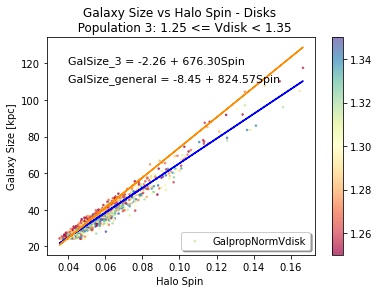

In [49]:
a10, b10 = np.polyfit(df_disks_bigv_3.loc[:, 'HalopropSpin'],df_disks_bigv_3.loc[:, 'GalpropNormHalfRadius'] , 1)

plt.scatter(df_disks_bigv_3.loc[:, 'HalopropSpin'], df_disks_bigv_3.loc[:, 'GalpropNormHalfRadius'],
            c = df_disks_bigv_3['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk') #, vmin=1.0, vmax=1.5)
plt.title('Galaxy Size vs Halo Spin - Disks \n  Population 3: 1.25 <= Vdisk < 1.35')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_disks_bigv_3.loc[:, 'HalopropSpin'], a10*df_disks_bigv_3.loc[:, 'HalopropSpin']+b10, color = 'blue') 
# line of best fit fromt he equation on the complete vdisk>1.0 population
plt.plot(df_disks_bigv_3.loc[:, 'HalopropSpin'], a4*df_disks_bigv_3.loc[:, 'HalopropSpin']+b4, color = 'darkorange') 

#add fitted regression equation to plot
plt.text(0.04, 120, 'GalSize_3 = ' + '{:.2f}'.format(b10) + ' + {:.2f}'.format(a10) + 'Spin', size=11)
plt.text(0.04, 110, 'GalSize_general = ' + '{:.2f}'.format(b4) + ' + {:.2f}'.format(a4) + 'Spin', size=11)
# plt.savefig('Size_vs_spin_disks_vdisk_3.jpeg', dpi=500)

plt.show()

#### <font color='darkgreen'> <a id =10> </a> <br>  1.d.4. Population 4: Vdisk >= 1.35 

In [50]:
# Big Vdisk Population 4: Vdisk >= 1.35
df_disks_bigv_4 = df_disks_bigv.loc[df_disks_bigv.GalpropNormVdisk>=1.35]

In [51]:
df_disks_bigv_4.shape

(552, 33)

In [52]:
df_disks_bigv_4['GalpropNormVdisk'].max()

1.7286558388609352

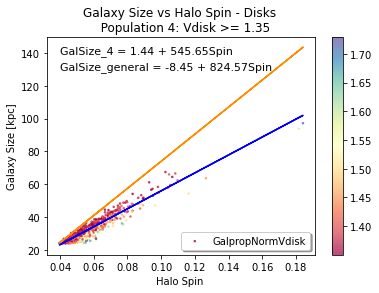

In [53]:
a11, b11 = np.polyfit(df_disks_bigv_4.loc[:, 'HalopropSpin'],df_disks_bigv_4.loc[:, 'GalpropNormHalfRadius'] , 1)

plt.scatter(df_disks_bigv_4.loc[:, 'HalopropSpin'], df_disks_bigv_4.loc[:, 'GalpropNormHalfRadius'],
            c = df_disks_bigv_4['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk') #, vmin=1.0, vmax=1.5)
plt.title('Galaxy Size vs Halo Spin - Disks \n  Population 4: Vdisk >= 1.35')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_disks_bigv_4.loc[:, 'HalopropSpin'], a11*df_disks_bigv_4.loc[:, 'HalopropSpin']+b11, color = 'blue') 
# line of best fit fromt he equation on the complete vdisk>1.0 population
plt.plot(df_disks_bigv_4.loc[:, 'HalopropSpin'], a4*df_disks_bigv_4.loc[:, 'HalopropSpin']+b4, color = 'darkorange') 

#add fitted regression equation to plot
plt.text(0.04, 140, 'GalSize_4 = ' + '{:.2f}'.format(b11) + ' + {:.2f}'.format(a11) + 'Spin', size=11)
plt.text(0.04, 130, 'GalSize_general = ' + '{:.2f}'.format(b4) + ' + {:.2f}'.format(a4) + 'Spin', size=11)
# plt.savefig('Size_vs_spin_disks_vdisk_4.jpeg', dpi=500)

plt.show()

In [54]:
slopes_per_vdiskbin = np.array ([a8, a9, a10, a11])

In [55]:
slopes_per_vdiskbin

array([939.75814902, 774.34104921, 676.30015001, 545.65117528])

In [56]:
vdiskbins = np.array([1,2,3,4])

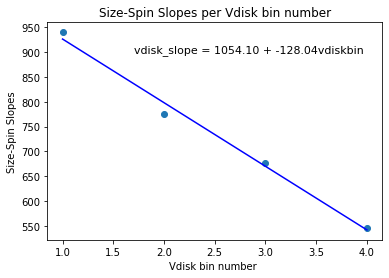

In [57]:
a12, b12 = np.polyfit(vdiskbins, slopes_per_vdiskbin, 1)
plt.scatter (vdiskbins, slopes_per_vdiskbin)

plt.plot(vdiskbins, a12*vdiskbins+b12, color = 'blue') 

plt.text(1.7, 900, 'vdisk_slope = ' + '{:.2f}'.format(b12) + ' + {:.2f}'.format(a12) + 'vdiskbin', size=11)

plt.title('Size-Spin Slopes per Vdisk bin number')
plt.ylabel('Size-Spin Slopes')
plt.xlabel('Vdisk bin number ')
# plt.savefig('Size_spin_slopes_per_vdiskbin.jpeg', dpi=500)

plt.show()

In [58]:
(df_disks['GalpropNormVdisk'].values > 1.0) & (df_disks['GalpropNormVdisk'].values <=1.15)
# use .values in order to obtain an array of true/false statements; otherwise, it is not an array and np.piecewise doesn't work

array([False, False, False, ..., False, False, False])

In [59]:
vdisk = df_disks_wosmallgalaxies['GalpropNormVdisk'].values

In [60]:
vdisk_slopes_func = np.piecewise(vdisk, 
              [vdisk <= 1.0, # small vdisk
              (vdisk > 1.0) & (vdisk <=1.15), # big vdisk, pop1
              (vdisk > 1.15) & (vdisk <=1.25), # big vdisk pop2
              (vdisk > 1.25) & (vdisk <=1.35), # big vdisk pop3
              vdisk > 1.35, # big vdisk pop4 
             ], [a2, a8, a9, a10, a11])

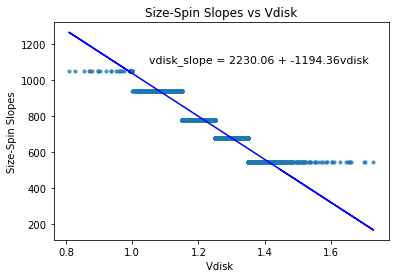

In [61]:
a13, b13 = np.polyfit(vdisk, vdisk_slopes_func, 1)


plt.scatter(vdisk, vdisk_slopes_func, s=10, alpha=0.7)

plt.plot(vdisk, a13*vdisk+b13, color = 'blue') 

plt.text(1.05, 1100, 'vdisk_slope = ' + '{:.2f}'.format(b13) + ' + {:.2f}'.format(a13) + 'vdisk', size=11)

plt.title('Size-Spin Slopes vs Vdisk')
plt.ylabel('Size-Spin Slopes')
plt.xlabel('Vdisk ')
# plt.savefig('Size_spin_slopes_per_all_vdisk_values.jpeg', dpi=500)

plt.show()

In [62]:
df_disks['GalpropNormVdisk'].values

array([1.30061629, 0.99308368, 0.99308274, ..., 0.99308287, 0.99308286,
       1.44336581])

In [63]:
df_disks['GalpropNormVdisk'].max() # max vdisk of all disk galaxies is 2.4

2.3810423180443605

In [64]:
df_disks_wosmallgalaxies['GalpropNormVdisk'].max() # removing small galaxies with size<=24 kpc decreases max vdisk to 1.7. This means that those small galaxies have very high velocities

1.7286558388609352

### Intercept vs big vdisk values only

In [65]:
df_big_vdisk = (df_disks_wosmallgalaxies.loc[df_disks_wosmallgalaxies.GalpropNormVdisk > 1.0])

In [66]:
big_vdisk = df_big_vdisk['GalpropNormVdisk'].values

In [67]:
big_vdisk.shape

(4071,)

In [68]:
vdisk_intercept_func_bigv = np.piecewise(big_vdisk, 
              [
              (big_vdisk > 1.0) & (big_vdisk <=1.15), # big vdisk, pop1
              (big_vdisk > 1.15) & (big_vdisk <=1.25), # big vdisk pop2
              (big_vdisk > 1.25) & (big_vdisk <=1.35), # big vdisk pop3
              big_vdisk > 1.35, # big vdisk pop4 
             ], [ b8, b9, b10, b11])

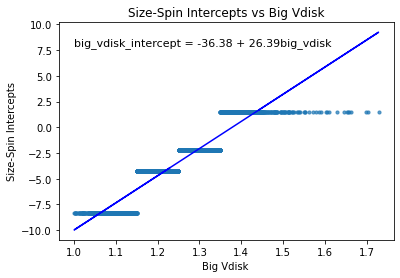

In [69]:
a14, b14 = np.polyfit(big_vdisk, vdisk_intercept_func_bigv, 1)


plt.scatter(big_vdisk, vdisk_intercept_func_bigv, s=10, alpha=0.7)

plt.plot(big_vdisk, a14*big_vdisk+b14, color = 'blue') 

plt.text(1.0, 8.0, 'big_vdisk_intercept = ' + '{:.2f}'.format(b14) + ' + {:.2f}'.format(a14) + 'big_vdisk', size=11)

plt.title('Size-Spin Intercepts vs Big Vdisk')
plt.ylabel('Size-Spin Intercepts')
plt.xlabel('Big Vdisk ')
# plt.savefig('Size_spin_intercept_per_big_vdisk_values.jpeg', dpi=500)

plt.show()

### Intercept vs all vdisk values

In [70]:
vdisk_intercept_func = np.piecewise(vdisk, 
              [vdisk <= 1.0, # small vdisk
              (vdisk > 1.0) & (vdisk <=1.15), # big vdisk, pop1
              (vdisk > 1.15) & (vdisk <=1.25), # big vdisk pop2
              (vdisk > 1.25) & (vdisk <=1.35), # big vdisk pop3
              vdisk > 1.35, # big vdisk pop4 
             ], [b2, b8, b9, b10, b11])

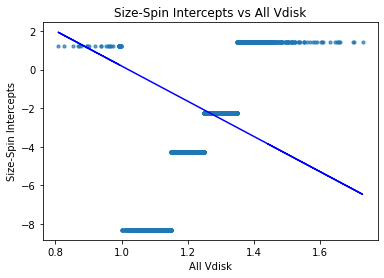

In [71]:
a15, b15 = np.polyfit(vdisk, vdisk_intercept_func, 1)


plt.scatter(vdisk, vdisk_intercept_func, s=10, alpha=0.7)

plt.plot(vdisk, a15*vdisk+b15, color = 'blue') 

# plt.text(1.05, 1100, 'vdisk_intercept = ' + '{:.2f}'.format(b15) + ' + {:.2f}'.format(a15) + 'vdisk', size=11)

plt.title('Size-Spin Intercepts vs All Vdisk')
plt.ylabel('Size-Spin Intercepts')
plt.xlabel('All Vdisk')
# plt.savefig('Size_spin_intercepts_per_all_vdisk_values.jpeg', dpi=500)

plt.show()

### Plotting slopes vs mean vdisk

In [72]:
df_small_vdisk = (df_disks_wosmallgalaxies.loc[df_disks_wosmallgalaxies.GalpropNormVdisk <= 1.0])

In [73]:
small_vdisk = df_small_vdisk['GalpropNormVdisk'].values

In [74]:
small_vdisk

array([0.99308368, 0.99308274, 0.99308327, ..., 0.99308414, 0.99308287,
       0.99308286])

In [75]:
mean_small_vdisk = df_small_vdisk['GalpropNormVdisk'].mean()

In [76]:
df_big_vdisk_1 = (df_big_vdisk.loc[(df_big_vdisk.GalpropNormVdisk >= 1.0) &  (df_big_vdisk.GalpropNormVdisk <1.15)])

In [77]:
big_vdisk_1 = df_big_vdisk_1['GalpropNormVdisk'].values


In [78]:
mean_big_vdisk_1 = df_big_vdisk_1['GalpropNormVdisk'].mean()

In [79]:
df_big_vdisk_2 = (df_big_vdisk.loc[(df_big_vdisk.GalpropNormVdisk >= 1.15) &  (df_big_vdisk.GalpropNormVdisk <1.25)])

In [80]:
big_vdisk_2 = df_big_vdisk_2['GalpropNormVdisk'].values

In [81]:
mean_big_vdisk_2 = df_big_vdisk_2['GalpropNormVdisk'].mean()

In [82]:
df_big_vdisk_3 = (df_big_vdisk.loc[(df_big_vdisk.GalpropNormVdisk >= 1.25) &  (df_big_vdisk.GalpropNormVdisk <1.35)])

In [83]:
big_vdisk_3 = df_big_vdisk_3['GalpropNormVdisk'].values

In [84]:
mean_big_vdisk_3 = df_big_vdisk_3['GalpropNormVdisk'].mean()

In [85]:
df_big_vdisk_4 = (df_big_vdisk.loc[df_big_vdisk.GalpropNormVdisk >= 1.35])

In [86]:
big_vdisk_4 = df_big_vdisk_4['GalpropNormVdisk'].values

In [87]:
mean_big_vdisk_4 = df_big_vdisk_4['GalpropNormVdisk'].mean()

In [88]:
mean_vdisk_values = [mean_small_vdisk, mean_big_vdisk_1, mean_big_vdisk_2, mean_big_vdisk_3, mean_big_vdisk_4]

In [89]:
mean_vdisk_values = np.array(mean_vdisk_values) # convert list into np.array

In [90]:
slopes_values = [a2, a8, a9, a10, a11] # list

In [91]:
slopes_values = np.array(slopes_values) # convert list into np.array

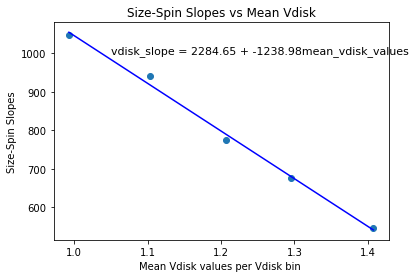

In [92]:
a16, b16 = np.polyfit(mean_vdisk_values, slopes_values, 1)


plt.scatter(mean_vdisk_values, slopes_values, )

plt.plot(mean_vdisk_values, a16*mean_vdisk_values+b16, color = 'blue') 

plt.text(1.05, 1000, 'vdisk_slope = ' + '{:.2f}'.format(b16) + ' + {:.2f}'.format(a16) + 'mean_vdisk_values', size=11)

plt.title('Size-Spin Slopes vs Mean Vdisk')
plt.ylabel('Size-Spin Slopes')
plt.xlabel('Mean Vdisk values per Vdisk bin ')
# plt.savefig('Size_spin_slopes_per_mean_vdisk_values.jpeg', dpi=500)

plt.show()

### <font color='orange'> <a id =15> </a> <br>  1.e. Physical formula for Disks

In [93]:
from scipy.optimize import curve_fit

### case0: size_0 = a + b*spin + c*vdisk + d*spin*vdisk function

In [94]:
def spin_vdisk_func(spin_vdisk, a, b, c, d):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    return a + b*spin_vdisk[0] + c * spin_vdisk[1]  + d * spin_vdisk[0] * spin_vdisk[1]

In [95]:
HalopropSpin = np.array(df_disks_wosmallgalaxies['HalopropSpin'])

In [96]:
GalpropNormVdisk = np.array(df_disks_wosmallgalaxies['GalpropNormVdisk'])

In [97]:
Size = np.array(df_disks_wosmallgalaxies['GalpropNormHalfRadius'])

In [98]:
spin_vdisk = [HalopropSpin, GalpropNormVdisk]

In [99]:
spin_vdisk = np.array (spin_vdisk) # convert list into array

In [100]:
popt, pcov = curve_fit(spin_vdisk_func, spin_vdisk, Size)

In [101]:
popt

array([  31.84203782, 1666.3928364 ,  -27.30751953, -746.23630166])

In [102]:
size_0 = spin_vdisk_func(spin_vdisk, *popt)

In [103]:
size_0.shape

(9463,)

In [104]:
Size.shape

(9463,)

In [106]:
# r2_score(y_true, y_pred)
r2_score_size_funcsize_0=r2_score(Size, size_0)

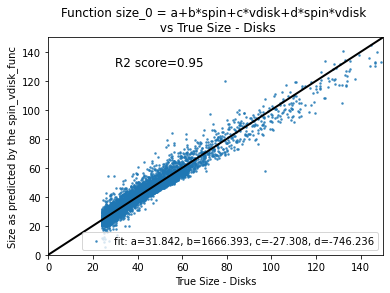

In [107]:
plt.scatter(Size, size_0, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_0), size=12)
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,150, 0.0,150])
plt.title('Function size_0 = a+b*spin+c*vdisk+d*spin*vdisk \n vs True Size - Disks')
plt.ylabel('Size as predicted by the spin_vdisk_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_0.jpeg', dpi=500)
plt.show()

### case 1: size_1 = a + b*spin + d*spin*vdisk function

In [109]:
def spin_vdisk_func_1(spin_vdisk, a, b, d):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    return a + b*spin_vdisk[0]  + d * spin_vdisk[0] * spin_vdisk[1]

In [110]:
popt_1, pcov_1 = curve_fit(spin_vdisk_func_1, spin_vdisk, Size)

In [111]:
size_1 = spin_vdisk_func_1(spin_vdisk, *popt_1)

In [112]:
r2_score_size_funcsize_1=r2_score(Size, size_1)

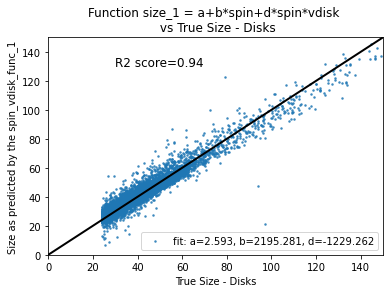

In [114]:
plt.scatter(Size, size_1, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f' % tuple(popt_1))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_1), size=12)
plt.title('Function size_1 = a+b*spin+d*spin*vdisk \n vs True Size - Disks')
plt.ylabel('Size as predicted by the spin_vdisk_func_1')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_1.jpeg', dpi=500)
plt.show()

### case 2: size_2 = spin/vdisk function

In [116]:
def spin_over_vdisk_func(spin_vdisk, a, b):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    return a + b*spin_vdisk[0]*(1/ spin_vdisk[1])

In [117]:
popt_2, pcov_2 = curve_fit(spin_over_vdisk_func, spin_vdisk, Size)

In [118]:
size_2 = spin_over_vdisk_func(spin_vdisk, *popt_2)

In [120]:
r2_score_size_funcsize_2=r2_score(Size, size_2)

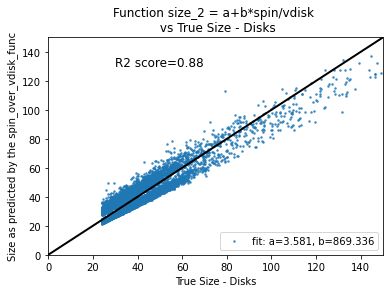

In [121]:
plt.scatter(Size, size_2, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f' % tuple(popt_2))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_2), size=12)
plt.title('Function size_2 = a+b*spin/vdisk \n vs True Size - Disks')
plt.ylabel('Size as predicted by the spin_over_vdisk_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_2.jpeg', dpi=500)
plt.show()

### case 3: size_3 = spin/vdisk^2 function (the function predicted by SR)

In [123]:
def spin_over_vdisk_squared_func(spin_vdisk, a, b):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
    return a + b*spin_vdisk[0]*(1/ (spin_vdisk[1])**2)

In [124]:
popt_3, pcov_3 = curve_fit(spin_over_vdisk_squared_func, spin_vdisk, Size)

In [125]:
size_3 = spin_over_vdisk_squared_func(spin_vdisk, *popt_3)

In [126]:
r2_score_size_funcsize_3=r2_score(Size, size_3)

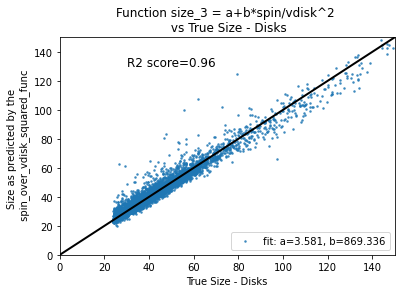

In [127]:
plt.scatter(Size, size_3, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f' % tuple(popt_2))
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_3), size=12)
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_3 = a+b*spin/vdisk^2 \n vs True Size - Disks')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_3.jpeg', dpi=500)
plt.show()

### case 4: size_4 = a + b*spin + d*spin*vdisk + e*(Mbulge/Mstar)



In [128]:
def spin_vdisk_bulgemstar_func(spin_vdisk_bmstar, a, b, d, e):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk_bmstar[0]
    # vdisk is spin_vdisk_bmstar[1]
    # Mbulge/Mstar is spin_vdisk_bmstar[2]
    return a + b*spin_vdisk_bmstar[0]  + d * spin_vdisk_bmstar[0] * spin_vdisk_bmstar[1] + e*spin_vdisk_bmstar[2]

In [129]:
BulgeMstar = np.array (df_disks_wosmallgalaxies.loc[:, 'BulgeMstar_ratio'])

spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])

In [130]:
popt_4, pcov_4 = curve_fit(spin_vdisk_bulgemstar_func, spin_vdisk_bmstar, Size)

size_4 = spin_vdisk_bulgemstar_func(spin_vdisk_bmstar, *popt_4)

r2_score_size_funcsize_4=r2_score(Size, size_4)

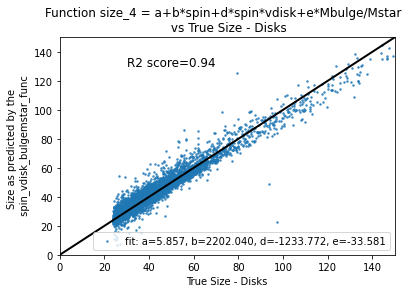

In [228]:
plt.scatter(Size, size_4, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt_4))
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_4), size=12)
plt.title('Function size_4 = a+b*spin+d*spin*vdisk+e*Mbulge/Mstar  \n vs True Size - Disks')
plt.ylabel('Size as predicted by the \n spin_vdisk_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_4.jpeg', dpi=500)
plt.show()

### case 5: size_5 = a + b*spin + d*spin*vdisk + f*ln(1-Mbulge/Mstar)

In [132]:
def spin_vdisk_log_bulgemstar_func(spin_vdisk_bmstar, a, b, d, f):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is spin_vdisk_bmstar[0]
    # vdisk is spin_vdisk_bmstar[1]
    # Mbulge/Mstar is spin_vdisk_bmstar[2]
    # Note that the last term of the func makes use of the natural logarithm (base e), not log10
    return a + b*spin_vdisk_bmstar[0]  + d * spin_vdisk_bmstar[0] * spin_vdisk_bmstar[1] + f*np.log(1-spin_vdisk_bmstar[2])

In [133]:
popt_5, pcov_5 = curve_fit(spin_vdisk_log_bulgemstar_func, spin_vdisk_bmstar, Size)

In [230]:
size_5 = spin_vdisk_log_bulgemstar_func(spin_vdisk_bmstar, *popt_5)

In [231]:
r2_score_size_funcsize_5=r2_score(Size, size_5)

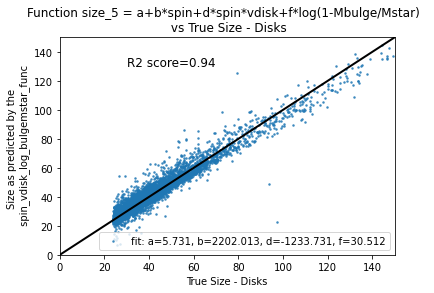

In [233]:
plt.scatter(Size, size_5, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f, f=%5.3f' % tuple(popt_5))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_5), size=12)
plt.title('Function size_5 = a+b*spin+d*spin*vdisk+f*log(1-Mbulge/Mstar)  \n vs True Size - Disks')
plt.ylabel('Size as predicted by the \n spin_vdisk_log_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_5.jpeg', dpi=500)
plt.show()

### case 6: size_6 = spin/vdisk^2 + Mbulge/Mstar function {(the function predicted by SR) + Mbulge/Mstar term}

In [137]:
def spin_over_vdisk_squared_bulgemstar_func(spin_vdisk_bmstar, a, b, g):
    # spin_vdisk_bmstar is a 3,M array that contains HalopropSpin and GalpropNormVdisk and Mbulge/Mstar
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
     # Mbulge/Mstar is spin_vdisk_bmstar[2]
    return a + b*spin_vdisk_bmstar[0]*(1/ (spin_vdisk_bmstar[1])**2) + g*spin_vdisk_bmstar[2]

In [138]:
popt_6, pcov_6 = curve_fit(spin_over_vdisk_squared_bulgemstar_func, spin_vdisk_bmstar, Size)

In [139]:
size_6 = spin_over_vdisk_squared_bulgemstar_func(spin_vdisk_bmstar, *popt_6)

In [140]:
r2_score_size_funcsize_6=r2_score(Size, size_6)

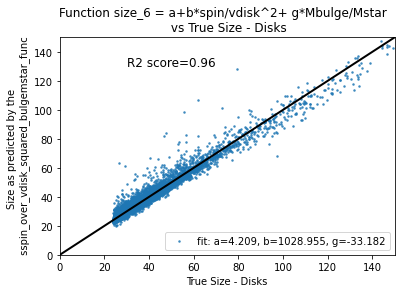

In [141]:
plt.scatter(Size, size_6, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f, g=%5.3f' % tuple(popt_6))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_6), size=12)
plt.title('Function size_6 = a+b*spin/vdisk^2+ g*Mbulge/Mstar  \n vs True Size - Disks')
plt.ylabel('Size as predicted by the \n sspin_over_vdisk_squared_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_6.jpeg', dpi=500)
plt.show()

### case 7: size_7 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) function {(the function predicted by SR) + log(1-Mbulge/Mstar) term}

In [142]:
def spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar, a, b, h):
    # spin_vdisk_bmstar is a 3,M array that contains HalopropSpin and GalpropNormVdisk and Mbulge/Mstar
    # spin is spin_vdisk[0]
    # vdisk is spin_vdisk[1]
     # Mbulge/Mstar is spin_vdisk_bmstar[2]
    return a + b*spin_vdisk_bmstar[0]*(1/ (spin_vdisk_bmstar[1])**2) + h*np.log(1-spin_vdisk_bmstar[2])

In [143]:
popt_7, pcov_7 = curve_fit(spin_over_vdisk_squared_log_bulgemstar_func, spin_vdisk_bmstar, Size)

In [144]:
size_7 = spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar, *popt_7)

In [145]:
r2_score_size_funcsize_7=r2_score(Size, size_7)

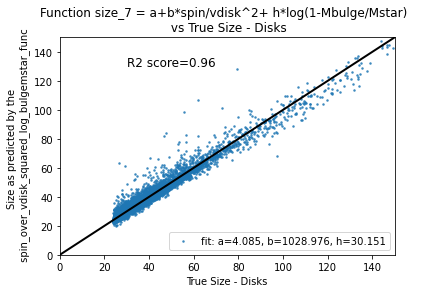

In [147]:
plt.scatter(Size, size_7, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f' % tuple(popt_7))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_7), size=12)
plt.title('Function size_7 = a+b*spin/vdisk^2+ h*log(1-Mbulge/Mstar)  \n vs True Size - Disks')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_log_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_7.jpeg', dpi=500)
plt.show()

### case 8: size_8 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) + j*MHI function

In [148]:
MHI = np.array (df_disks_wosmallgalaxies.loc[:, 'GalpropNormMHI'])

spin_vdisk_bmstar_MHI = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar, MHI])

In [149]:
def spin_over_vdisk_squared_log_bulgemstar_MHI_func(spin_vdisk_bmstar_MHI, a, b, h, j):
    # spin_vdisk_bmstar is a 4,M array that contains HalopropSpin and GalpropNormVdisk and Mbulge/Mstar
    # spin is spin_vdisk_MHI[0]
    # vdisk is spin_vdisk_MHI[1]
    # Mbulge/Mstar is spin_vdisk_bmstar_MHI[2]
    # MHI is spin_vdisk_bmstar_MHI[3]    
    return a + b*spin_vdisk_bmstar_MHI[0]*(1/ (spin_vdisk_bmstar_MHI[1])**2) + h*np.log(1-spin_vdisk_bmstar_MHI[2]) + j*spin_vdisk_bmstar_MHI[3]

In [150]:
popt_8, pcov_8 = curve_fit(spin_over_vdisk_squared_log_bulgemstar_MHI_func, spin_vdisk_bmstar_MHI, Size)

size_8 = spin_over_vdisk_squared_log_bulgemstar_MHI_func(spin_vdisk_bmstar_MHI, *popt_8)

r2_score_size_funcsize_8=r2_score(Size, size_8)

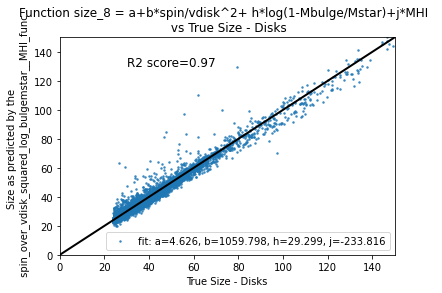

In [151]:
plt.scatter(Size, size_8, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f, j=%5.3f' % tuple(popt_8))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_8), size=12)
plt.title('Function size_8 = a+b*spin/vdisk^2+ h*log(1-Mbulge/Mstar)+j*MHI  \n vs True Size - Disks')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_log_bulgemstar__MHI_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_8.jpeg', dpi=500)
plt.show()

### case 9: size_9 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) + spin*MHI function


In [152]:
def MHI_spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar_MHI, a, b, h, j):
    # spin_vdisk_bmstar is a 4,M array that contains HalopropSpin and GalpropNormVdisk and Mbulge/Mstar
    # spin is spin_vdisk_MHI[0]
    # vdisk is spin_vdisk_MHI[1]
    # Mbulge/Mstar is spin_vdisk_bmstar_MHI[2]
    # MHI is spin_vdisk_bmstar_MHI[3]    
    return a + b*spin_vdisk_bmstar_MHI[0]*(1/ (spin_vdisk_bmstar_MHI[1])**2) + h*np.log(1-spin_vdisk_bmstar_MHI[2]) + j*spin_vdisk_bmstar_MHI[0]*spin_vdisk_bmstar_MHI[3]

In [153]:
popt_9, pcov_9 = curve_fit(MHI_spin_over_vdisk_squared_log_bulgemstar_func, spin_vdisk_bmstar_MHI, Size)

size_9 = MHI_spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar_MHI, *popt_9)

r2_score_size_funcsize_9=r2_score(Size, size_9)

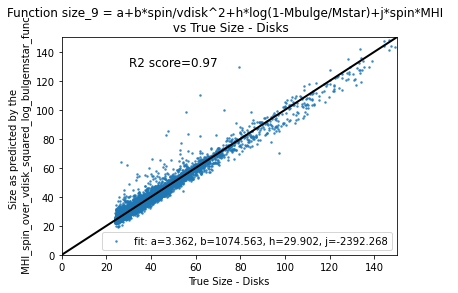

In [154]:
plt.scatter(Size, size_9, marker='.', s=10, alpha=0.7,
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f, j=%5.3f' % tuple(popt_9))
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,150, 0.0,150])
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_9), size=12)
plt.title('Function size_9 = a+b*spin/vdisk^2+h*log(1-Mbulge/Mstar)+j*spin*MHI  \n vs True Size - Disks')
plt.ylabel('Size as predicted by the \n MHI_spin_over_vdisk_squared_log_bulgemstar_func')
plt.xlabel('True Size - Disks')
plt.legend(loc = 'lower right')
# plt.savefig('Disks_TrueSize_vs_FunctionSize_9.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =20> </a> <br> 2. Bulgy Disk Galaxies: 0.15< B/Mstar <=0.3

In [155]:
df_bulgy_disks = pd.read_csv('Bulgy Disks Dataset_as defined in notebook v13')

In [156]:
df_bulgy_disks.shape

(12949, 33)

In [157]:
X_bulgy_disks = df_bulgy_disks.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_bulgy_disks = df_bulgy_disks.loc[:,'GalpropNormHalfRadius']

In [158]:
# choose the 7 most important features from analysis above to be used for physical modelling

X_bulgy_disks_imp = df_bulgy_disks.loc[:, ['HalopropSpin', 'GalpropNormVdisk',
                              'GalpropNormSigmaBulge', 'HalopropC_nfw', 'GalpropNormMcold',
                              'GalpropTmerger', 'GalpropOutflowRate_Metal' ]]


y_bulgy_disks_imp = df_bulgy_disks.loc[:, 'GalpropNormHalfRadius']

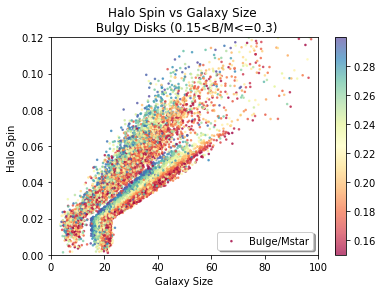

In [159]:
plt.scatter(y_bulgy_disks_imp, X_bulgy_disks_imp.loc[:, 'HalopropSpin'],
            c = df_bulgy_disks['BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'Bulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Bulgy Disks (0.15<B/M<=0.3)')
plt.xlabel('Galaxy Size')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_bulgy_disks_bulgemstarcolor.jpeg', dpi=500)
plt.show()

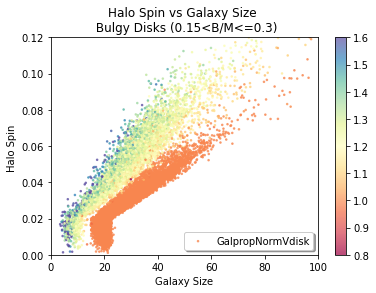

In [160]:
plt.scatter(y_bulgy_disks_imp, X_bulgy_disks_imp.loc[:, 'HalopropSpin'],
            c = df_bulgy_disks['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=0.8, vmax=1.6)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Bulgy Disks (0.15<B/M<=0.3)')
plt.xlabel('Galaxy Size')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_bulgy_disks_vdiskcolor_scaleconstrained.jpeg', dpi=500)
plt.show()

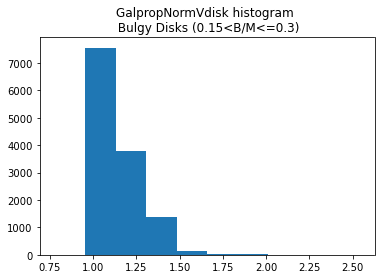

In [161]:
plt.hist(df_bulgy_disks['GalpropNormVdisk'])
plt.title('GalpropNormVdisk histogram \n Bulgy Disks (0.15<B/M<=0.3)')
# plt.savefig('GalpropNormVdisk_bulgy_disks_histogram', dpi=500)
plt.show()

In [162]:
df_bulgy_disks_wosmallgalaxies = df_bulgy_disks.loc[df_bulgy_disks.GalpropNormHalfRadius > 20]



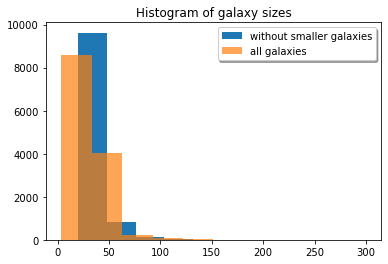

In [163]:
plt.hist (df_bulgy_disks_wosmallgalaxies['GalpropNormHalfRadius'], label = 'without smaller galaxies')
plt.hist (df_bulgy_disks['GalpropNormHalfRadius'], alpha=0.7, label = 'all galaxies')
plt.title ('Histogram of galaxy sizes')
plt.legend (loc='upper right' , shadow=True)
plt.show()

In [164]:
Size_bulgy = np.array(df_bulgy_disks['GalpropNormHalfRadius'])

In [165]:
HalopropSpin_bulgy = df_bulgy_disks.loc[:, 'HalopropSpin']

In [166]:
HalopropSpin_bulgy = np.array(HalopropSpin_bulgy)

In [167]:
HalopropSpin_bulgy

array([0.01407, 0.02229, 0.04394, ..., 0.01507, 0.03464, 0.00996])

In [168]:
GalpropNormVdisk_bulgy = df_bulgy_disks.loc[:, 'GalpropNormVdisk']

In [169]:
GalpropNormVdisk_bulgy = np.array(GalpropNormVdisk_bulgy)

In [170]:
GalpropNormVdisk_bulgy

array([0.99308381, 0.99308334, 0.99308457, ..., 0.99308408, 1.43220775,
       0.99308337])

### case 0: using size_0 = a+b*spin+c*vdisk+d*spin*vdisk equation from Disks on Bulgy Disks

In [171]:
spin_vdisk_bulgy = [HalopropSpin_bulgy, GalpropNormVdisk_bulgy]

In [172]:
# check if equation 0 from Disks population can predict sizes of Bulgy Disks
size_0_bulgy = spin_vdisk_func(spin_vdisk_bulgy, *popt)

In [173]:
r2_score_size_funcsize_0_bulgy=r2_score(Size_bulgy, size_0_bulgy)

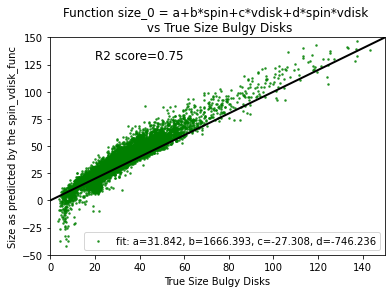

In [175]:
plt.scatter(Size_bulgy, size_0_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_0_bulgy), size=12)
plt.axis([0.0,150, -50,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_0 = a+b*spin+c*vdisk+d*spin*vdisk \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the spin_vdisk_func')
plt.xlabel('True Size Bulgy Disks')
plt.legend()
# plt.savefig('BulgyDisks_TrueSize_vs_Size_0.jpeg', dpi=500)
plt.show()

### case 1: Using size_1 = a + b*spin + d*spin*vdisk equation from Disks on Bulgy Disks

In [176]:
size_1_bulgy = spin_vdisk_func_1(spin_vdisk_bulgy, *popt_1)

In [177]:
r2_score_size_funcsize_1_bulgy=r2_score(Size_bulgy, size_1_bulgy)

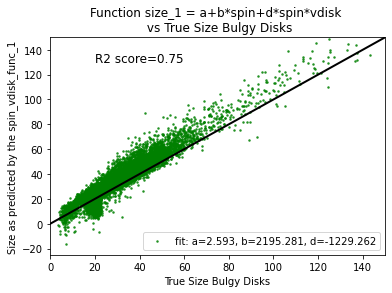

In [178]:
plt.scatter(Size_bulgy, size_1_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f' % tuple(popt_1))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_1_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)

plt.title('Function size_1 = a+b*spin+d*spin*vdisk \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the spin_vdisk_func_1')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_1.jpeg', dpi=500)
plt.show()

### case 2: Using size_2 = spin/vdisk equation from Disks on Bulgy Disks

In [179]:
size_2_bulgy = spin_over_vdisk_func(spin_vdisk_bulgy, *popt_2)

In [180]:
r2_score_size_funcsize_2_bulgy=r2_score(Size_bulgy, size_2_bulgy)

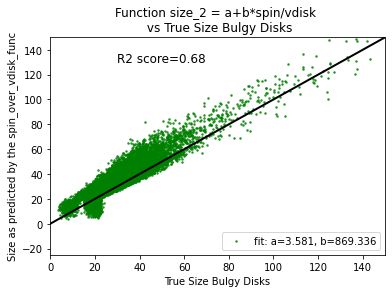

In [181]:
plt.scatter(Size_bulgy, size_2_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f' % tuple(popt_2))
plt.text(30, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_2_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)

plt.title('Function size_2 = a+b*spin/vdisk \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the spin_over_vdisk_func')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_2.jpeg', dpi=500)
plt.show()

### case 3: Using size_3 = spin/vdisk^2 equation (the function predicted by SR) from Disks on Bulgy Disks


In [182]:
size_3_bulgy = spin_over_vdisk_squared_func(spin_vdisk_bulgy, *popt_3)

In [183]:
r2_score_size_funcsize_3_bulgy=r2_score(Size_bulgy, size_3_bulgy)

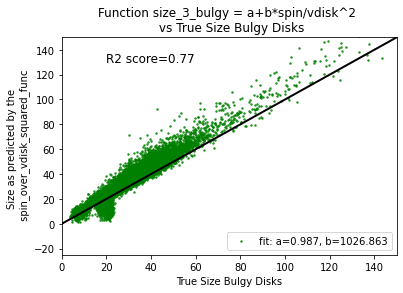

In [184]:
plt.scatter(Size_bulgy, size_3_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f' % tuple(popt_3))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_3_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_3_bulgy = a+b*spin/vdisk^2 \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_func')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_3.jpeg', dpi=500)
plt.show()

### case 3a: Using size_3a = spin/vdisk^2 equation (the function predicted by SR for Bulgy Disks)

In [185]:
# The SR best eqution for Bulgy Disks with n_iter=100: 914.50977*HalopropSpin/GalpropNormVdisk**2
size_3a_bulgy = 914.50977*HalopropSpin_bulgy/(GalpropNormVdisk_bulgy**2)

In [186]:
r2_score_size_funcsize_3a_bulgy=r2_score(Size_bulgy, size_3a_bulgy)

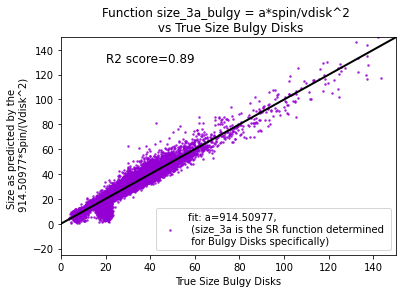

In [187]:
plt.scatter(Size_bulgy, size_3a_bulgy, marker='.', s=10, alpha=0.7, c='darkviolet',
        label='fit: a=914.50977, \n (size_3a is the SR function determined \n for Bulgy Disks specifically)')
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_3a_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_3a_bulgy = a*spin/vdisk^2 \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the \n 914.50977*Spin/(Vdisk^2)')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_3a_SR_specifically_forBulgyDisks.jpeg', dpi=500)
plt.show()

### case 4: Using size_4 = a + b*spin + d*spin*vdisk + e*(Mbulge/Mstar) from Disks on Bulgy Disks


In [188]:
BulgeMstar_bulgy = np. array(df_bulgy_disks.loc[:, 'BulgeMstar_ratio'])

In [189]:
spin_vdisk_bmstar_bulgy = [HalopropSpin_bulgy, GalpropNormVdisk_bulgy, BulgeMstar_bulgy]

In [190]:
spin_vdisk_bmstar_bulgy  = np.array (spin_vdisk_bmstar_bulgy )

In [191]:
size_4_bulgy = spin_vdisk_bulgemstar_func(spin_vdisk_bmstar_bulgy, *popt_4)

In [192]:
r2_score_size_funcsize_4_bulgy=r2_score(Size_bulgy, size_4_bulgy)

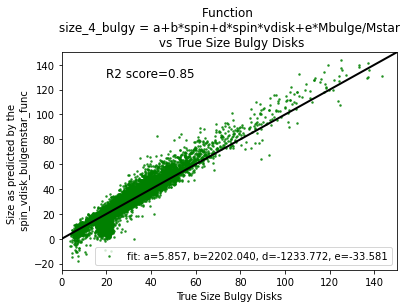

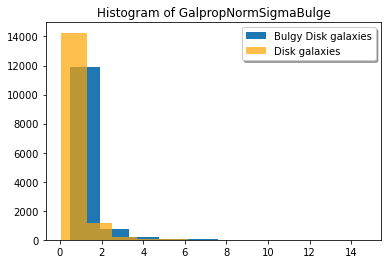

In [193]:
plt.scatter(Size_bulgy, size_4_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f, e=%5.3f' % tuple(popt_4))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_4_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function \n size_4_bulgy = a+b*spin+d*spin*vdisk+e*Mbulge/Mstar \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the \n spin_vdisk_bulgemstar_func')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_4.jpeg', dpi=500)
plt.show()

plt.hist(df_bulgy_disks['GalpropNormSigmaBulge'], label = 'Bulgy Disk galaxies')
plt.hist(df_disks['GalpropNormSigmaBulge'], alpha=0.7, color = 'orange', label = 'Disk galaxies')
plt.title ('Histogram of GalpropNormSigmaBulge')
plt.legend (loc='upper right' , shadow=True)
# plt.savefig('Disks_vs_BulgyDisks_GalpropNormSigmaBulge_histogram.jpeg', dpi=500)
plt.show()

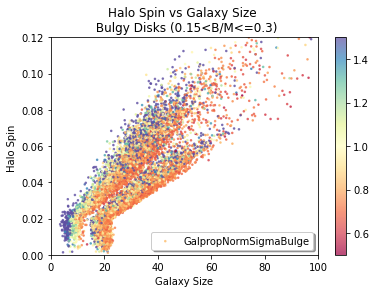

In [194]:
plt.scatter(y_bulgy_disks_imp, X_bulgy_disks_imp.loc[:, 'HalopropSpin'],
            c = df_bulgy_disks['GalpropNormSigmaBulge'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormSigmaBulge', vmin=0.5, vmax=1.5)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,100, 0.0,0.12])
plt.title('Halo Spin vs Galaxy Size \n Bulgy Disks (0.15<B/M<=0.3)')
plt.xlabel('Galaxy Size')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_bulgy_disks_sigmabulgecolor_scaleconstrained.jpeg', dpi=500)
plt.show()

### Relative Error for function size_4 = a + b*spin + d*spin*vdisk + e*(Mbulge/Mstar) 

In [195]:
relative_error_4_bulgy = (size_4_bulgy - Size_bulgy)/Size_bulgy

In [196]:
df_bulgy_disks_relerr = df_bulgy_disks

In [197]:
df_bulgy_disks_relerr.shape

(12949, 33)

In [198]:
df_bulgy_disks_relerr['Relative Error'] = relative_error_4_bulgy

In [199]:
df_bulgy_disks_relerr.shape

(12949, 34)

In [200]:
df_bulgy_disks_relerr_sample = df_bulgy_disks_relerr.sample(n = 1000, random_state = 2022)

In [201]:
df_bulgy_disks_relerr_sample.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMaccdot_radio', 'GalpropMu_merger', 'GalpropOutflowRate_Mass',
       'GalpropOutflowRate_Metal', 'GalpropSfr', 'GalpropSfrave100myr',
       'GalpropSfrave1gyr', 'GalpropSfrave20myr', 'GalpropTmerger',
       'GalpropTmerger_major', 'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_radio', 'HalopropMaccdot_reaccreate',
       'HalopropMetal_ejected', 'HalopropSpin', 'HalopropZhot',
       'GalpropNormHalfRadius', 'GalpropNormMstar', 'HalopropNormMhot',
       'GalpropNormMbulge', 'GalpropNormMBH', 'GalpropNormMH2',
       'GalpropNormMHI', 'GalpropNormMHII', 'GalpropNormMcold',
       'GalpropNormMstar_merge', 'HalopropNormMass_ejected',
       'HalopropNormMstar_diffuse', 'GalpropNormSigmaBulge',
       'GalpropNormVdisk', 'BulgeMstar_ratio', 'Relative Error'],
      dtype='object')>

In [202]:
df_bulgy_disks_relerr_sample = df_bulgy_disks_relerr_sample.loc[:, ['HalopropSpin',                                                 
                            'GalpropNormVdisk', 'GalpropNormSigmaBulge', 'HalopropC_nfw', 'GalpropNormMcold',
                            'GalpropTmerger', 'GalpropOutflowRate_Metal', 'HalopropNormMstar_diffuse',
                            'GalpropNormMbulge', 'GalpropTmerger_major', 'HalopropMetal_ejected',
                             'GalpropNormMstar', 'GalpropNormMHI', 'GalpropNormHalfRadius',
                             'BulgeMstar_ratio', 'Relative Error']]

In [203]:
df_bulgy_disks_relerr_sample.shape

(1000, 16)

### Size vs C_nfw

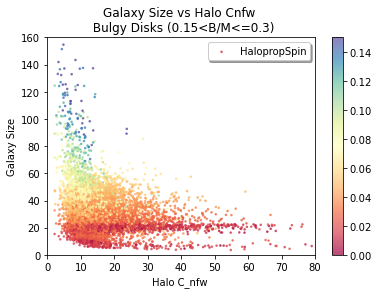

In [204]:
plt.scatter( X_bulgy_disks_imp.loc[:, 'HalopropC_nfw'], y_bulgy_disks_imp,
            c = df_bulgy_disks['HalopropSpin'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'HalopropSpin', vmin=0.0, vmax=0.15)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,80, 0.0,160])
plt.title('Galaxy Size vs Halo Cnfw \n Bulgy Disks (0.15<B/M<=0.3)')
plt.ylabel('Galaxy Size')
plt.xlabel('Halo C_nfw ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('Size_vs_Cnfw_bulgy_disks_spincolor_scaleconstrained.jpeg', dpi=500)
plt.show()

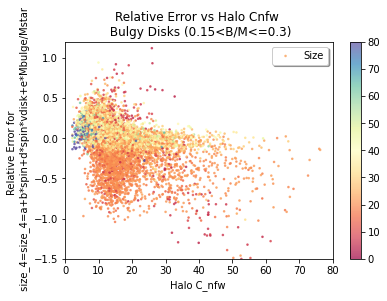

In [205]:
plt.scatter(X_bulgy_disks_imp.loc[:, 'HalopropC_nfw'], relative_error_4_bulgy,
            c = df_bulgy_disks['GalpropNormHalfRadius'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'Size', vmin=0.0, vmax=80)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([0.0,80, -1.5,1.2])
plt.title('Relative Error vs Halo Cnfw \n Bulgy Disks (0.15<B/M<=0.3)')
plt.ylabel('Relative Error for \n size_4=size_4=a+b*spin+d*spin*vdisk+e*Mbulge/Mstar')
plt.xlabel('Halo C_nfw ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('RelativeError4_vs_Cnfw_bulgy_disks_sizecolor_scaleconstrained.jpeg', dpi=500)
plt.show()

### Relative Error vs Halo Mass - is there dependence on Halo Mass?

In [206]:
# Load the raw TNG-SAM dataset (after analysis done on notebook v5)
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

In [207]:
df_log_mass_filtered_v5.shape

(35390, 66)

In [208]:
# add the Bulge/Mstar ratio column to the raw dataset
df_log_mass_filtered_v5.loc[:, 'BulgeMstar_ratio'] = df_log_mass_filtered_v5.loc[:,'GalpropMbulge']/df_log_mass_filtered_v5.loc[:, 'GalpropMstar']

In [209]:
# from the raw dataset choose only bulgy disk galaxies
df_raw_bulgy_disks = df_log_mass_filtered_v5.loc[(df_log_mass_filtered_v5.BulgeMstar_ratio>0.15)
                                                 & (df_log_mass_filtered_v5.BulgeMstar_ratio<=0.3)]

In [210]:
Mhalo_bulgy_disks = np.array(df_raw_bulgy_disks.loc[:, 'HalopropMvir'])

(array([  11.,   45.,  251., 2892., 5946., 2495.,  905.,  329.,   66.,
           9.]),
 array([ 9.37490042,  9.74486131, 10.11482219, 10.48478307, 10.85474395,
        11.22470483, 11.59466571, 11.9646266 , 12.33458748, 12.70454836,
        13.07450924]),
 <BarContainer object of 10 artists>)

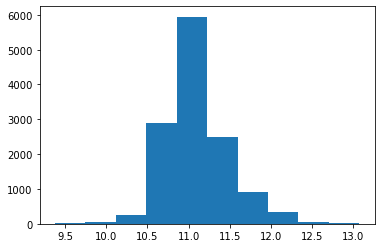

In [211]:
plt.hist(np.log10(Mhalo_bulgy_disks))

(array([8.610e+03, 4.046e+03, 2.080e+02, 6.300e+01, 2.000e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  3.58669013,  33.17901716,  62.7713442 ,  92.36367123,
        121.95599826, 151.54832529, 181.14065233, 210.73297936,
        240.32530639, 269.91763342, 299.50996046]),
 <BarContainer object of 10 artists>)

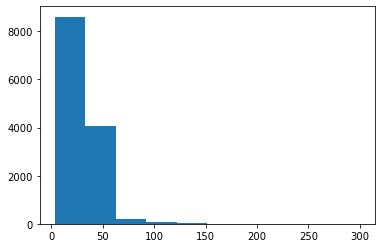

In [212]:
plt.hist(df_bulgy_disks['GalpropNormHalfRadius'])

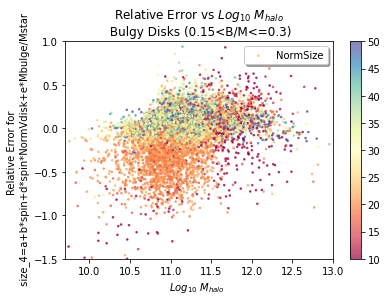

In [213]:
plt.scatter(np.log10(Mhalo_bulgy_disks), relative_error_4_bulgy,
            c = df_bulgy_disks['GalpropNormHalfRadius'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'NormSize', vmin=10.0, vmax=50)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([9.7,13, -1.5,1.0])
plt.title('Relative Error vs $ Log_{10} $ $M_{halo}$ \n Bulgy Disks (0.15<B/M<=0.3)')
plt.ylabel('Relative Error for \n size_4=a+b*spin+d*spin*NormVdisk+e*Mbulge/Mstar')
plt.xlabel('$ Log_{10} $ $M_{halo}$  ')
plt.legend(loc='upper right' , shadow=True)
plt.colorbar()
# plt.savefig('RelativeError4_vs_Mhalo_bulgy_disks_sizecolor_scaleconstrained.jpeg', dpi=500)
plt.show()
# $\log_{10} $  Galaxy Mass $[M_\odot] $

### case 5: Using size_5 = a + b*spin + d*spin*vdisk + f*ln(1-Mbulge/Mstar) from Disks on Bulgy Disks

In [214]:
size_5_bulgy = spin_vdisk_log_bulgemstar_func(spin_vdisk_bmstar_bulgy, *popt_5)

In [215]:
r2_score_size_funcsize_5_bulgy=r2_score(Size_bulgy, size_5_bulgy)

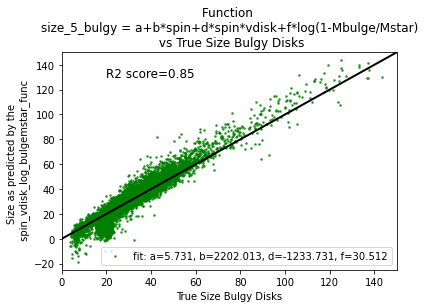

In [216]:
plt.scatter(Size_bulgy, size_5_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f, d=%5.3f, f=%5.3f' % tuple(popt_5))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_5_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function \n size_5_bulgy = a+b*spin+d*spin*vdisk+f*log(1-Mbulge/Mstar) \n vs True Size Bulgy Disks')
plt.ylabel('Size as predicted by the \n spin_vdisk_log_bulgemstar_func')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_5.jpeg', dpi=500)
plt.show()

### case 6: Using size_6 = spin/vdisk^2 + g*Mbulge/Mstar equation (the function predicted by SR + Mbulge/Mstar term) from Disks on  Bulgy Disks

In [217]:
size_6_bulgy = spin_over_vdisk_squared_bulgemstar_func(spin_vdisk_bmstar_bulgy, *popt_6)

In [218]:
r2_score_size_funcsize_6_bulgy=r2_score(Size_bulgy, size_6_bulgy)

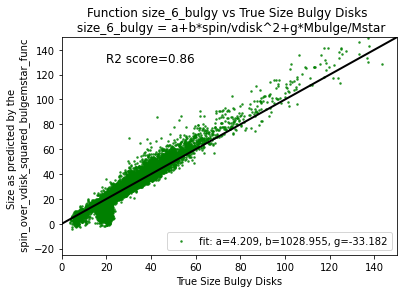

In [219]:
plt.scatter(Size_bulgy, size_6_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f, g=%5.3f' % tuple(popt_6))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_6_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_6_bulgy vs True Size Bulgy Disks \n size_6_bulgy = a+b*spin/vdisk^2+g*Mbulge/Mstar')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_bulgemstar_func')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_6.jpeg', dpi=500)
plt.show()

### case 7: Using size_7 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) equation (the function predicted by SR + log(1-Mbulge/Mstar) term from Disks on Bulgy Disks

In [220]:
size_7_bulgy = spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar_bulgy, *popt_7)

In [221]:
r2_score_size_funcsize_7_bulgy=r2_score(Size_bulgy, size_7_bulgy)

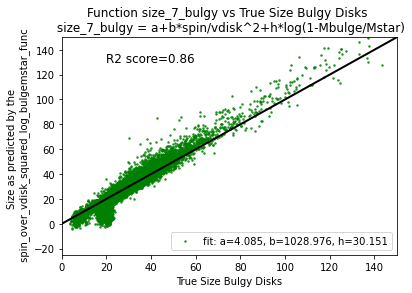

In [222]:
plt.scatter(Size_bulgy, size_7_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f' % tuple(popt_7))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_7_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_7_bulgy vs True Size Bulgy Disks \n size_7_bulgy = a+b*spin/vdisk^2+h*log(1-Mbulge/Mstar)')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_log_bulgemstar_func')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_7.jpeg', dpi=500)
plt.show()

### case 8: Using size_8 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) + j*MHI function from Disks on Bulgy Disks

In [223]:
MHI_bulgy = np.array (df_bulgy_disks.loc[:, 'GalpropNormMHI'])

spin_vdisk_bmstar_MHI_bulgy = np. array([HalopropSpin_bulgy, GalpropNormVdisk_bulgy, BulgeMstar_bulgy, MHI_bulgy])

In [224]:
size_8_bulgy = spin_over_vdisk_squared_log_bulgemstar_MHI_func(spin_vdisk_bmstar_MHI_bulgy, *popt_8)

r2_score_size_funcsize_8_bulgy=r2_score(Size_bulgy, size_8_bulgy)

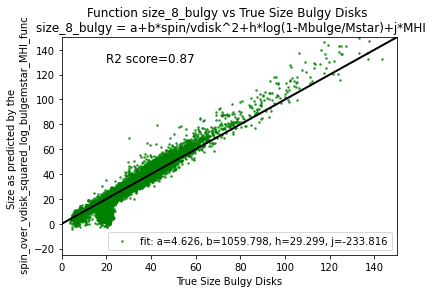

In [225]:
plt.scatter(Size_bulgy, size_8_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f, j=%5.3f' % tuple(popt_8))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_8_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_8_bulgy vs True Size Bulgy Disks \n size_8_bulgy = a+b*spin/vdisk^2+h*log(1-Mbulge/Mstar)+j*MHI')
plt.ylabel('Size as predicted by the \n spin_over_vdisk_squared_log_bulgemstar_MHI_func')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_8.jpeg', dpi=500)
plt.show()

### case 9: size_9 = spin/vdisk^2 + h*log(1-Mbulge/Mstar) + spin*MHI funtion from Disks on Bulgy Disks

In [226]:
size_9_bulgy = MHI_spin_over_vdisk_squared_log_bulgemstar_func(spin_vdisk_bmstar_MHI_bulgy, *popt_9)

r2_score_size_funcsize_9_bulgy=r2_score(Size_bulgy, size_9_bulgy)

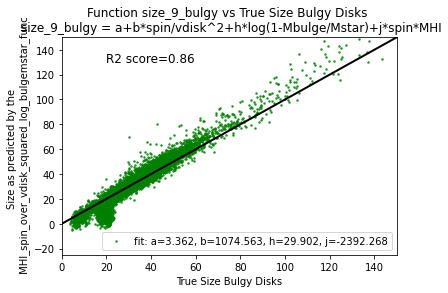

In [227]:
plt.scatter(Size_bulgy, size_9_bulgy, marker='.', s=10, alpha=0.7, c='green',
        label='fit: a=%5.3f, b=%5.3f, h=%5.3f, j=%5.3f' % tuple(popt_9))
plt.text(20, 130, 'R2 score=' + '{:.2f}'.format(r2_score_size_funcsize_9_bulgy), size=12)
plt.axis([0.0,150, -25,150])
plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.title('Function size_9_bulgy vs True Size Bulgy Disks \n size_9_bulgy = a+b*spin/vdisk^2+h*log(1-Mbulge/Mstar)+j*spin*MHI')
plt.ylabel('Size as predicted by the \n MHI_spin_over_vdisk_squared_log_bulgemstar_func')
plt.xlabel('True Size Bulgy Disks')
plt.legend(loc = 'lower right')
# plt.savefig('BulgyDisks_TrueSize_vs_Size_9.jpeg', dpi=500)
plt.show()

### <font color='darkorange'> <a id =21> </a> <br>  2.b. Bulgy Disks' Small vdiks: Vdisk<=1.0 cases

In [213]:
df_bulgy_disks_smallv = df_bulgy_disks.loc[df_bulgy_disks.GalpropNormVdisk<=1.0]

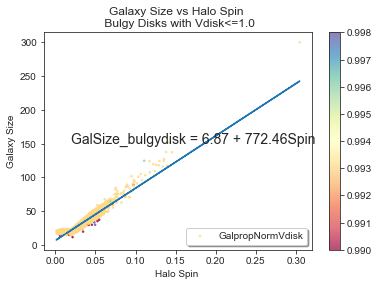

In [214]:
#find line of best fit
m1, n1 = np.polyfit(df_bulgy_disks_smallv.loc[:, 'HalopropSpin'],df_bulgy_disks_smallv.loc[:, 'GalpropNormHalfRadius'] , 1)

plt.scatter(df_bulgy_disks_smallv.loc[:, 'HalopropSpin'], df_bulgy_disks_smallv.loc[:, 'GalpropNormHalfRadius'],
            c = df_bulgy_disks_smallv['GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'GalpropNormVdisk', vmin=0.99, vmax=0.998)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
# plt.axis([0.0,100, 0.0,0.12])
plt.title('Galaxy Size vs Halo Spin \n Bulgy Disks with Vdisk<=1.0')
plt.ylabel('Galaxy Size')
plt.xlabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()


#add line of best fit to plot
plt.plot(df_bulgy_disks_smallv.loc[:, 'HalopropSpin'], m1*df_bulgy_disks_smallv.loc[:, 'HalopropSpin']+n1) 

#add fitted regression equation to plot
plt.text(0.02, 150, 'GalSize_bulgydisk = ' + '{:.2f}'.format(n1) + ' + {:.2f}'.format(m1) + 'Spin', size=14)
# plt.savefig('Size_vs_spin_bulgy_disks_smallvdisk_polyfit.jpeg', dpi=500)
plt.show()